# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [3]:
training_file = 'dataset/train.p'
validation_file = 'dataset/valid.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = np.shape(X_train[0])
n_classes = len(np.unique(y_train))
print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

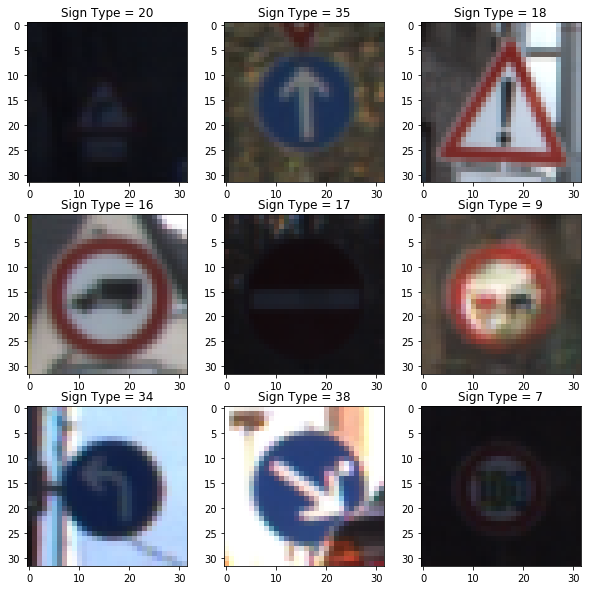

In [5]:
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(image)
    ax.set_title('Sign Type = '+str(y_train[index]))
plt.savefig('fig1.png')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
# Grayscale & Normalize Images
def grayscale_normalize(array):
    grayscale_data = []
    for i in range(0,array.shape[0]):
        grayscale_data.append(cv2.cvtColor(array[i], cv2.COLOR_RGB2GRAY))
    grayscale_data = np.array(grayscale_data)
    grayscale_data = grayscale_data.reshape([-1, image_shape[0], image_shape[1], 1])
    return (grayscale_data - 128.0) / 128.0

X_train = grayscale_normalize(X_train)
X_valid = grayscale_normalize(X_valid)
X_test = grayscale_normalize(X_test)

### Model Architecture

In [9]:
EPOCHS = 10
BATCH_SIZE = 64
rate = 0.001

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# Layer 1: Convolutional.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(32))
conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
conv1 = tf.nn.relu(conv1)
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Layer 2: Convolutional.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(64))
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
conv2 = tf.nn.relu(conv2)
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Flatten.
fc0   = flatten(conv2)

# Layer 3: Fully Connected.
fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 320), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(320))
fc1   = tf.matmul(fc0, fc1_W) + fc1_b
fc1    = tf.nn.relu(fc1)

# Layer 4: Fully Connected.
fc2_W  = tf.Variable(tf.truncated_normal(shape=(320, 43), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(43))
logits = tf.matmul(fc1, fc2_W) + fc2_b

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        test_accuracy = evaluate(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
        
    saver.save(sess, './YS_net')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.966
Validation Accuracy = 0.892
Test Accuracy = 0.879

EPOCH 2 ...
Train Accuracy = 0.983
Validation Accuracy = 0.903
Test Accuracy = 0.907

EPOCH 3 ...
Train Accuracy = 0.986
Validation Accuracy = 0.907
Test Accuracy = 0.900

EPOCH 4 ...
Train Accuracy = 0.990
Validation Accuracy = 0.928
Test Accuracy = 0.920

EPOCH 5 ...
Train Accuracy = 0.996
Validation Accuracy = 0.929
Test Accuracy = 0.925

EPOCH 6 ...
Train Accuracy = 0.997
Validation Accuracy = 0.939
Test Accuracy = 0.928

EPOCH 7 ...
Train Accuracy = 0.995
Validation Accuracy = 0.920
Test Accuracy = 0.926

EPOCH 8 ...
Train Accuracy = 0.995
Validation Accuracy = 0.928
Test Accuracy = 0.915

EPOCH 9 ...
Train Accuracy = 0.997
Validation Accuracy = 0.935
Test Accuracy = 0.926

EPOCH 10 ...
Train Accuracy = 0.997
Validation Accuracy = 0.944
Test Accuracy = 0.933

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

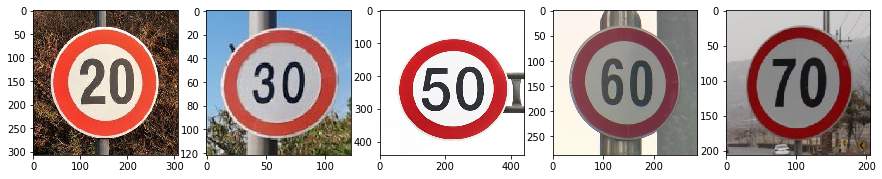

In [15]:
X_new = []
imgdir = 'dataset_new/'
imglist = ['20.jpg', '30.jpg', '50.jpg', '60.jpg', '70.jpg']
plt.figure(figsize=(15,3))
for i in range(0, 5):
    imgname = imglist[i]
    image = mpimg.imread(imgdir+imgname)
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    X_new.append(image)
X_new = np.array(X_new).reshape([-1, image_shape[0], image_shape[1], 1])
plt.savefig('fig2.png')

### Predict the Sign Type for Each Image

In [16]:
y_new = [0,1,2,3,4] # Prediction on the sign type

### Analyze Performance

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_new, y_new)
    print("Test Accuracy (NEW) = {:.3f}".format(test_accuracy))
    print()

INFO:tensorflow:Restoring parameters from ./YS_net
Test Accuracy (NEW) = 0.800



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [18]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for i in range(0,5):
        X_current = X_new[i].reshape([-1, image_shape[0], image_shape[1], 1])
        tmp = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: X_current})
        
        values = list(tmp.values[0])
        indices = list(tmp.indices[0])
        maximum = max(values)
        rest = np.sum(values)-maximum
        print("Image%g-Probabilities:"%i, values , "Predicted Image:", indices)
        print("Max:%f"%maximum, "Others:%f"%rest) #, maximum+rest
    
        if i in indices:
            print("Image is in the top 5 predictions")
        else:
            print("Image is NOT in the top 5 predictions")
        print()

INFO:tensorflow:Restoring parameters from ./YS_net
Image0-Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0] Predicted Image: [0, 1, 2, 3, 4]
Max:1.000000 Others:0.000000
Image is in the top 5 predictions

Image1-Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0] Predicted Image: [1, 0, 2, 3, 4]
Max:1.000000 Others:0.000000
Image is in the top 5 predictions

Image2-Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0] Predicted Image: [2, 0, 1, 3, 4]
Max:1.000000 Others:0.000000
Image is in the top 5 predictions

Image3-Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0] Predicted Image: [2, 0, 1, 3, 4]
Max:1.000000 Others:0.000000
Image is in the top 5 predictions

Image4-Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0] Predicted Image: [4, 0, 1, 2, 3]
Max:1.000000 Others:0.000000
Image is in the top 5 predictions



### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.